In [1]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime
import os.path
import datetime
from importlib import reload

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [97]:
# Import self-made modules
from utils import *
from autoencoder import AutoEncoder

In [98]:
# Reload libraries when changes have been made to them
%reload_ext autoreload
%autoreload 2

In [9]:
# Set file path constants
DATA_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/'

In [34]:
# Set parameters
WIN_SIZE = 20
SENSORS = ['back_angle', 'left_angle', 'right_angle']
no_feats = len(SENSORS)
train_type = 'Control'

THRESHOLD_ORIGIN = 'Test'
if THRESHOLD_ORIGIN == 'Train':
    THRESHOLD_PCT = 0.75
elif THRESHOLD_ORIGIN == 'Test':
    THRESHOLD_PCT = 0.75
FIXED = False

In [35]:
# Obtain test data
if train_type == 'Augment':
    test_type = 'minor'
elif train_type == 'Control':
    test_type = 'full'

In [36]:
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-{test_type}-test.npy'
path = DATA_FILE_PATH + file_name
testX = np.load(path)
print(f'Number of testing samples: {testX.shape}')

Number of testing samples: (38167, 20, 3)


In [108]:
# Retrieve test data for plotting and place with pd dataframe
patient_file_path = f'/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/{test_type}-test-{WIN_SIZE}.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['Date'])
test_df = dataframe.loc[:,SENSORS]
test_df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'Date'])

test_df.head()

,back_angle,left_angle,right_angle,Date
0,0.424307,0.572584,0.215395,2011-12-01 11:04:05.000
1,0.456290,0.568733,0.200416,2011-12-01 11:04:05.050
2,0.488273,0.564883,0.200416,2011-12-01 11:04:05.100
3,0.530917,0.557181,0.201110,2011-12-01 11:04:05.150
4,0.573561,0.541779,0.200416,2011-12-01 11:04:05.200


In [109]:
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-{train_type.lower()}-train.npy'
path = DATA_FILE_PATH + file_name
trainX = np.load(path)
print(f'Number of training samples: {trainX.shape}')

Number of training samples: (12022, 20, 3)


In [110]:
# Load the model in
if train_type == 'Augment':
    time_code = '111000_0429'
elif train_type == 'Control':
    time_code = '112000_0429'
model_file = f'{time_code}-model.h5'
model_file

'112000_0429-model.h5'

In [111]:
model = AutoEncoder(None, None, None, None, model_file, DIAGRAM_FILE_PATH)

Checking for 112000_0429-model.h5

Model loaded from: 112000_0429-model.h5
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 15)                1140      
_________________________________________________________________
dropout_22 (Dropout)         (None, 15)                0         
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 20, 15)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 20, 15)            1860      
_________________________________________________________________
dropout_23 (Dropout)         (None, 20, 15)            0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 3)             48        
Total params: 3,048
Trainable params: 3,048


In [112]:
# Reconstruct test signal
recon_test = model.model.predict(testX)
recon_test.shape

(38167, 20, 3)

In [113]:
error_types = ['MAE', 'Area']
test_MAE = error_computation(testX, recon_test, error_types[0])
test_MAE_df = anomaly_df(test_df, WIN_SIZE, test_MAE, 0)
test_area_error = error_computation(testX, recon_test, error_types[1])
test_area_df = anomaly_df(test_df, WIN_SIZE, test_area_error, 0)
test_errors = [test_MAE, test_area_error]

In [148]:
test_dfs = [test_MAE_df, test_area_df]

In [149]:
start = test_MAE_df['Date'].iloc[0]
end = test_MAE_df['Date'].iloc[-1]

In [150]:
# Reconstruct train signal
recon_train = model.model.predict(trainX)
recon_train.shape

(12022, 20, 3)

In [151]:
train_MAE = error_computation(trainX, recon_train, error_types[0])
train_area_error = error_computation(trainX, recon_train, error_types[1])
train_errors = [train_MAE, train_area_error]

In [152]:
if THRESHOLD_ORIGIN == 'Train':
    errors = train_errors[:]
elif THRESHOLD_ORIGIN == 'Test':
    errors = test_errors[:]

In [153]:
if FIXED:
    thresholds, plt = multiple_error_hist_plot_and_save(errors, error_types, f'Threshold={int(THRESHOLD_PCT*100)}% of Max {THRESHOLD_ORIGIN} Error', DIAGRAM_FILE_PATH, label_ypos=1000, traintest=THRESHOLD_ORIGIN, pct=THRESHOLD_PCT,save_new=False)

In [154]:
if FIXED:
    multiple_error_plot_and_save(test_dfs, error_types, f'Threshold={int(THRESHOLD_PCT*100)}% of Max {THRESHOLD_ORIGIN} Error', DIAGRAM_FILE_PATH, thresholds=thresholds, save_new=False)

In [155]:
error_dfs, anomalies_dfs = moving_thresholds(test_dfs)

In [156]:
error_dfs

[       back_angle  left_angle  right_angle                    Date     error  \
 20       0.541578    0.480169     0.201803 2011-12-01 11:04:06.000  0.038529   
 21       0.552239    0.480169     0.200832 2011-12-01 11:04:06.050  0.031573   
 22       0.552239    0.476319     0.201803 2011-12-01 11:04:06.100  0.027124   
 23       0.552239    0.480169     0.201526 2011-12-01 11:04:06.150  0.026665   
 24       0.552239    0.476319     0.202497 2011-12-01 11:04:06.200  0.026681   
 ...           ...         ...          ...                     ...       ...   
 38182    0.626866    0.276088     0.527046 2011-12-01 11:35:54.100  0.047279   
 38183    0.626866    0.276088     0.525659 2011-12-01 11:35:54.150  0.046433   
 38184    0.616205    0.276088     0.524272 2011-12-01 11:35:54.200  0.046014   
 38185    0.616205    0.276088     0.524272 2011-12-01 11:35:54.250  0.047080   
 38186    0.616205    0.276088     0.524272 2011-12-01 11:35:54.300  0.049432   
 
        thresh  anomaly  T

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

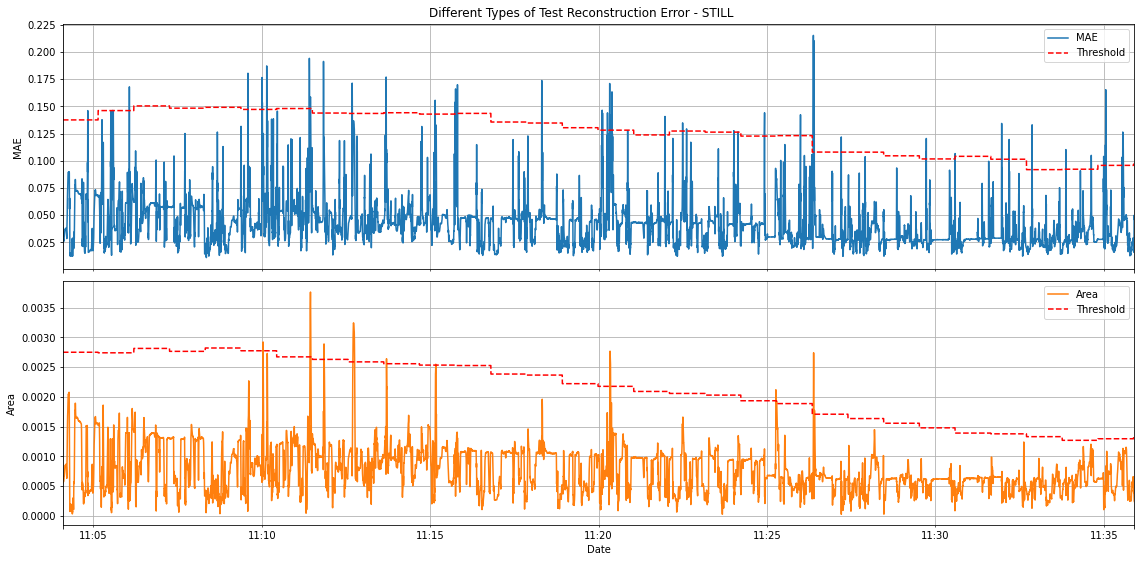

In [158]:
multiple_error_moving_thresh_plot_and_save(error_dfs, error_types, f'Locally Adaptive Threshold', DIAGRAM_FILE_PATH, save_new=False)